# Learning PageRank

### Overview

This Jupyter Notebook covers the **implementation of two simple Graph Neural Networks** (GNN) that are able to learn and determine the PageRank value of a graph.

As such, the repository covers:
- A program to compute the PageRank value of a given graph
- A random graph generator based on Erdos' random graph and scale-free generation
- A GNN with relaxation
- A GNN with a convolutional graph approach

The python implementations are available in the `script` folder and will be imported in this notebook. 

#### Note & Citation

This notebook relies heavily on the `networkx` library:

> Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

### Library imports

```sh
pip install dgl==0.6.1
pip install torch==1.9.1
```

In [3]:
import networkx as nx
import numpy as np

from scripts.dataset import generate_graph_dataset
from scripts.functions import generate_erdos_graph, generate_scale_free_graph
from scripts.functions import plot_graph
from scripts.page_rank import page_rank
from scripts.random_graph_generator import Random_Graph_Generator

%matplotlib inline

## 1. Implementing a Custom PageRank Function

### 1.1. The Concept of PageRank

#### Overview

PageRank or $PR$ is an link analysis algorithm used by Google to rank web pages. 

Considering pages as node of a (web)graph, hyperlinks or references between pages are considered as edges of said graph. The PageRank of a node is the numerical weight representing the importance of the node in the graph, which is computed by the number of incoming link to the node existing within the graph itself. 

> Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.

#### Overview of the Algorithm

The PageRank algorithm is recursive as any PageRank value of a node of a graph is derived from the PageRank values of other nodes. 

<u>Initialization:</u>

Given a graph $G$ with nodes $\forall i\in\{0,1,\ldots,n\}, N_i\in G$. Edges corresponds to links between each nodes (no node self-references). Each node is initialized with a PageRank value drawn from a probability distribution with domain $[0,1]$ and summing to 1. 

A node $N_i$ transfers its PageRank value to the node $N_j$ it references (i.e. via an outbound link $N_i\rightarrow N_j$). The value transfer is done in equal proportion between each link $\forall j\in\{0,\ldots,n\},i\neq j, N_i\rightarrow N_j$. 

<u>Page Rank computation:</u>

As such, the PageRank amount granted to a node $N_j$ from a node $N_i$ via an outbound link $N_i\rightarrow N_j$ is:

$\forall i, j\in\{0,1,\ldots,n\},i\neq j,$
\begin{align}
N_i, N_j&\in G\\
PR_{\text{transferred},\,N_i\rightarrow N_j}(N_i)&=\frac{PR(N_i)}{L(N_i)}\\
L(N_i)&=\overset{n}{\underset{i=0\\i\neq j}{\sum}}\mathbb{1}_{\exists N_i\rightarrow N_j}
\end{align}

Consequently, the PageRank value of a single node $N_i$ is:

$$\forall i, j\in\{0,1,\ldots,n\},i\neq j,\,PR(N_i)=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}PR_{\text{transferred},\,N_j\rightarrow N_i}(N_j)\big)$$

With $\mathcal{M}(i)$ the set of nodes $N_j$ that link to node $N_i$, $d$ a damping vactor (often set to $0.85$) that captures the idea that a random walker on the web will continue clicking on links on a page/node as a reducing rate.

#### Note on PageRank and Message Passing Models

We find some similarities between the way PageRank is computed and a generic model description of Graph Neural Networks based on message exchange among neighbors. Many GNN models can be described using this formalism called *Message Passing*, which helps understand how information propagates within a graph.

<center><img src="assets/message_passing.gif" width="400"></center>

### 1.2. Iterative Implementation

We decide to implement PageRank's iterative method described as such:

#### Initialization

- $n$, the number of nodes in the graph
- $t=0$, the starting timestep
- $\forall i\in\{0, \ldots, n\},\,PR(N_i; t=0)=\frac{1}{n}$, the starting PageRank of a node $N_i$ at time $t=0$
- $d\in[0, 1]$, the damping factor (usually set to $0.85$)
- $\epsilon$, an error parameter used to stop the algorithm

#### Iterative Steps

At each time step,

\begin{align}
\forall i\in\{0, \ldots, n\},\,PR(N_i; t+1)&=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}\frac{PR(N_j)}{L(N_j)}\big)\\
\end{align}

We denote $R(t)$ the column vector of length $n$ which row values are $\forall i \in \{0, \ldots, n\}, PR(N_i; t)$.

#### Iteration Stop

The above iterative process stops when: $$|R(t+1)-R(t)|<\epsilon$$

This assumes that the process has converged.

#### Example implementation

The full code is avalaible in the file `scripts/page_rank.py`.

In [4]:
# Generates a probabilistic transition matrix M
# of a graph with 10 nodes
M = np.random.random(size=(10, 10))
N = np.random.randint(0, 2, size=(10, 10))
M = M*N # adds zeros
M = M/M.sum(axis=0) # sums columns to one

print("Transition matrix M:\n", np.round(M, 1))

Transition matrix M:
 [[0.2 0.2 0.  0.3 0.  0.  0.  0.  0.  0. ]
 [0.2 0.4 0.2 0.  0.  0.  0.  0.  0.3 0. ]
 [0.  0.  0.2 0.1 0.  0.1 0.  0.  0.  0.2]
 [0.3 0.  0.  0.2 0.2 0.1 0.  0.  0.1 0. ]
 [0.  0.  0.1 0.2 0.4 0.  0.  0.5 0.3 0. ]
 [0.  0.  0.3 0.1 0.  0.3 0.4 0.4 0.1 0. ]
 [0.2 0.4 0.2 0.  0.  0.4 0.4 0.  0.  0.4]
 [0.  0.  0.  0.  0.4 0.  0.  0.1 0.  0.4]
 [0.  0.  0.  0.  0.  0.2 0.  0.  0.2 0. ]
 [0.  0.  0.  0.  0.  0.  0.2 0.  0.  0. ]]


In [5]:
# Computes the PageRank of each of the 10 nodes
page_rank(M, print_convergence=True)

PageRank converged at iteration 13 with epsilon=1e-05.


array([[0.06241366],
       [0.08368603],
       [0.06616555],
       [0.0797411 ],
       [0.12986393],
       [0.18257176],
       [0.20972864],
       [0.08216784],
       [0.04943928],
       [0.05422221]])

## 2. Generating Random Graphs

### 2.1. Generating an Example Erdos Graph

In [6]:
g = generate_erdos_graph(10, 0.3)

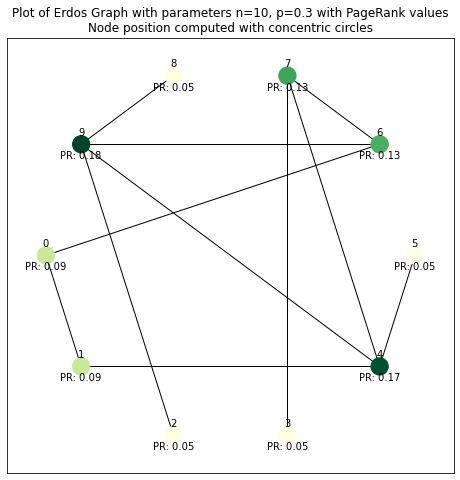

In [7]:
plot_graph(g, layout="shell")

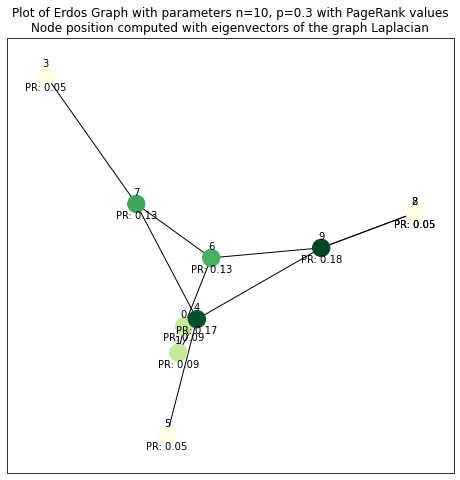

In [8]:
plot_graph(g, layout="spectral")

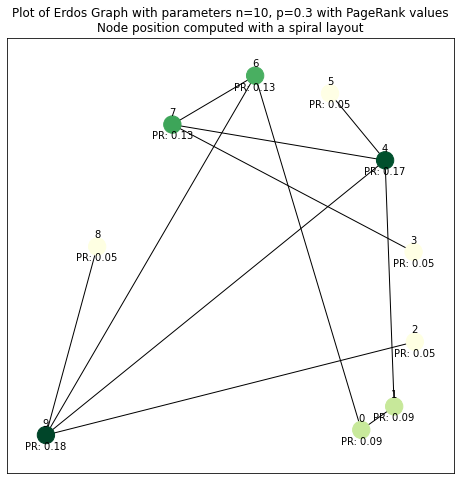

In [9]:
plot_graph(g, layout="spiral")

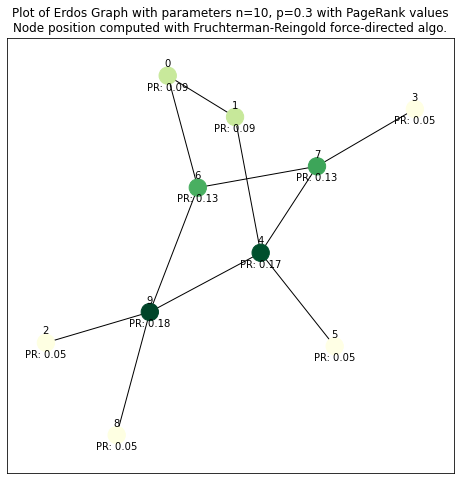

In [10]:
plot_graph(g, layout="spring")

### 2.2. Generating an Example Scale-Free Graph

In [11]:
g = generate_scale_free_graph(10)

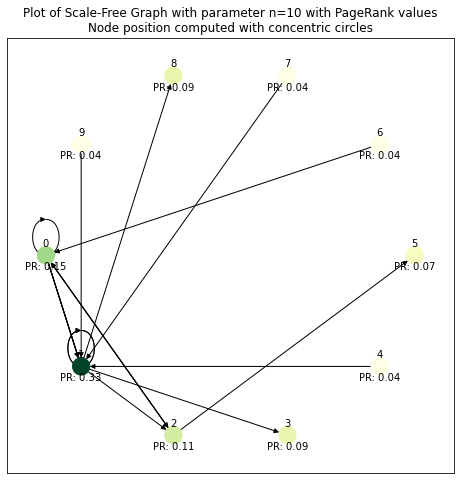

In [12]:
plot_graph(g, layout="shell")

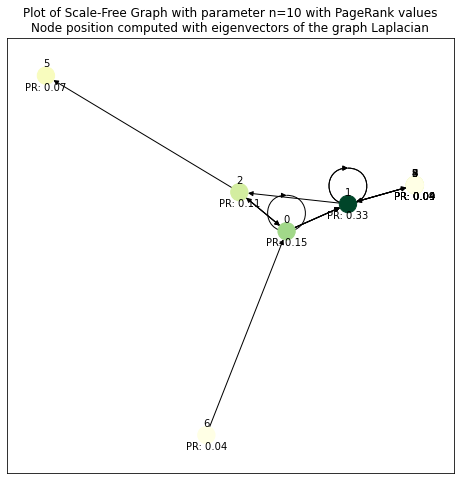

In [13]:
plot_graph(g, layout="spectral")

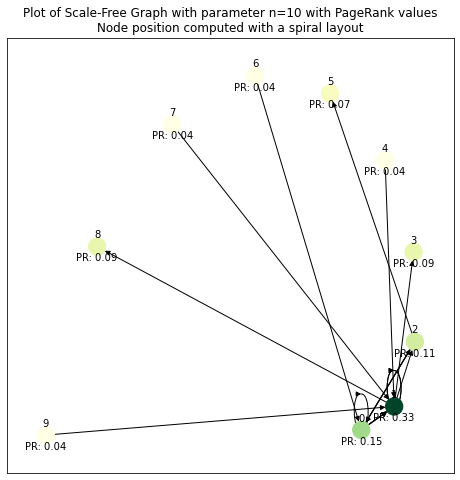

In [14]:
plot_graph(g, layout="spiral")

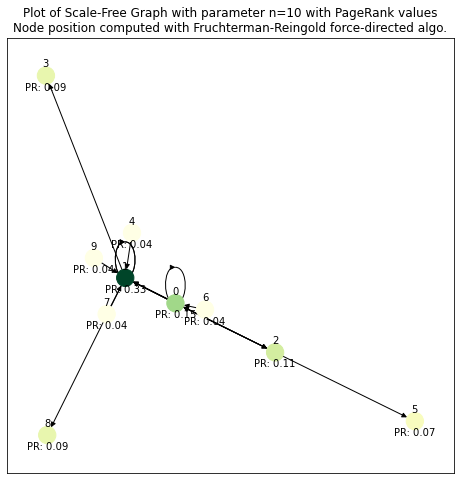

In [15]:
plot_graph(g, layout="spring")

### 2.2. Many Graphs Generation

#### Erdos' Method

The Erdős-Rényi graph or a binomial graph is a graph model that construct a graph $G_{n,p}$ where each of the possible edges between $n$ nodes appear with a fixed probability $p$. Each edge's probability of appearance is independent from the other edge's own probabilities.

> P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).

<u>Example</u>

In [16]:
erdos_generator = Random_Graph_Generator("erdos", True)
erdos_generator.graphs_generate(2000, 5, 0.5)
erdos_generator.graphs_page_rank_compute()
eX, ey = erdos_generator.graphs_retrieve()

Erdos Graph Generator declared
5 graphs were generated
PageRank values computed


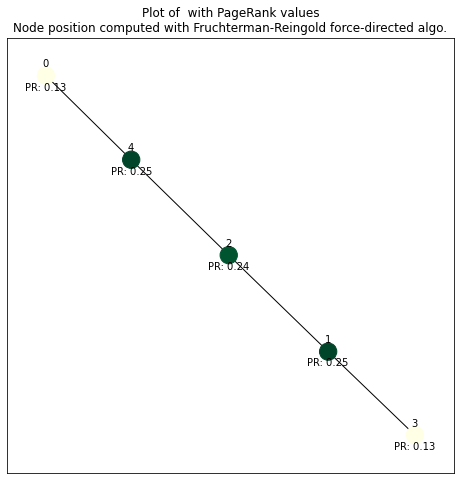

{0: 0.13452729038228986,
 1: 0.24594541923542018,
 2: 0.2390545807645797,
 3: 0.13452729038228986,
 4: 0.24594541923542018}

In [17]:
plot_graph(eX[1000])
ey[1000]

#### Scale-Free Method

The Scale-Free graph is a graph model that construct a graph $G_{n}$ of $n$ nodes with the property that the number of links $k$ originating from a given node exhibits a power law distribution $P(k)\sim k^(-\gamma)$. 

A scale-free network can be constructed by progressively adding nodes to an existing network and introducing links to existing nodes with preferential attachment so that the probability of linking to a given node $i$ is proportional to the number of existing links $k_i$ that node has such that:

$$P(\text{linking to node }i)\sim\frac{k_i}{\sum_jk_j}$$

> B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132--139, 2003.

<u>Example</u>

In [18]:
scalefree_generator = Random_Graph_Generator("scale-free", True)
scalefree_generator.graphs_generate(2000, 5)
scalefree_generator.graphs_page_rank_compute()
sfX, sfy = scalefree_generator.graphs_retrieve()

Scale-Free Graph Generator declared
5 graphs were generated
PageRank values computed


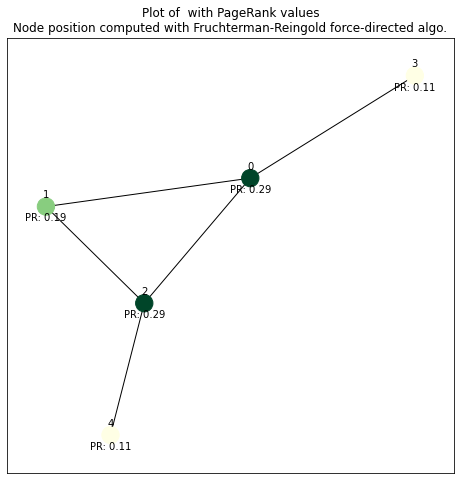

{0: 0.2904251934608255,
 1: 0.19457480653917453,
 2: 0.2904251934608255,
 3: 0.11228740326958728,
 4: 0.11228740326958728}

In [19]:
plot_graph(sfX[1000])
sfy[1000]

## 3. Learning PageRank

### 3.1. Building a Dataset
    
<u>Parameter selection</u>

To construct a dataset, we select:

- A **range of nodes $N$** to modulate the number of nodes in the graphs we want to create
- A selection of **graph-generating methods**. In our case: 
    - Erdos' method
    - Scale-Free method
- A **range of parameter values** for each parameter used to generate the graphs. In our case:
    - A range of probabilities $P$ to generate Erdos graphs
- A **number of graphs** to generate $n_{method}$ ***per given case and method***. In our case:
    - Erdos' method: we will obtain $n_{\text{erdos}}*len(P)*len(N)$
    - Scale-Free method: we will obtain $n_{\text{scale-free}}*len(N)$

As such, we choose to generate graphs with a 50/50 split between Erdos and Scale-Free graphs:

| Parameters | Description | Value | 
| :---: | :---: | :---: |
| P | Range of probabilities to generate Erdos graphs | {0.2, 0.3, 0.4, 0.5} |
| N |  Range of nodes to generate graphs |  {10, 25, 50, 75, 100} |
| $n_{\text{erdos}}$ | Number of Erdos graphs to generate per case | 5 | 
| $n_{\text{scale-free}}$ | Number of Scale-Free graphs to generate per case | 20 |


In [20]:
# Declares the parameters

P            = [0.2, 0.3, 0.4, 0.5]
N            = [5, 10, 25, 50, 100]
n_erdos      = 5
n_scale_free = 20

<u>Building the dataset</u>

We build 1,000 graphs each with a PageRank value per node, resulting in `25*5*(5+10+25+50+100)+100*(5+10+25+50+100)` nodes, i.e. 38,000 nodes, and on average c. 300,000 edges.

In [21]:
X, y = generate_graph_dataset(P, N, n_erdos, n_scale_free)

Generating Erdos graphs with parameters:
	Completed -- n=5, p=0.2
	Completed -- n=10, p=0.2
	Completed -- n=25, p=0.2
	Completed -- n=50, p=0.2
	Completed -- n=100, p=0.2
	Completed -- n=5, p=0.3
	Completed -- n=10, p=0.3
	Completed -- n=25, p=0.3
	Completed -- n=50, p=0.3
	Completed -- n=100, p=0.3
	Completed -- n=5, p=0.4
	Completed -- n=10, p=0.4
	Completed -- n=25, p=0.4
	Completed -- n=50, p=0.4
	Completed -- n=100, p=0.4
	Completed -- n=5, p=0.5
	Completed -- n=10, p=0.5
	Completed -- n=25, p=0.5
	Completed -- n=50, p=0.5
	Completed -- n=100, p=0.5

Generating Scale-Free graphs with parameter:
	Completed -- n=5
	Completed -- n=10
	Completed -- n=25
	Completed -- n=50
	Completed -- n=100


In [26]:
print(len(X), len(y))

200 200


In [27]:
print("Adjacency matrix of 0th graph:",
      nx.adjacency_matrix(X[0]).todense(),
      "\nPageRank values per node of 0th graph:",
      y[0],
      sep="\n")

Adjacency matrix of 0th graph:
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]

PageRank values per node of 0th graph:
{0: 0.03614469261482073, 1: 0.2409638268462948, 2: 0.2409638268462948, 3: 0.2409638268462948, 4: 0.2409638268462948}


<u>Merging all graphs into a single entity and saving it</u>

In [30]:
graphs = nx.read_graphml("graph_files/graph_record02112022.graphml")
pageranks = []
with open("graph_files/graph_record02112022_PageRanks.txt", 'r') as file:
    for row in file:
        pageranks.append(float(row))

In [32]:
print(len(graphs.nodes), len(graphs.edges))

7600 51190


### 3.2. Building Two Graph Neural Networks

<u>GNN with relaxation</u>

<u>Convolutional GNN</u>

### 3.3. Training the Graph Neural Networks

<u>GNN with relaxation</u>

<u>Convolutional GNN</u>

## 4. Discussing the Results

In [23]:
#https://github.com/HusseinLezzaik/Graph-Neural-Networks/blob/main/Make_your_own_dataset.py#



In [33]:
import networkx as nx
import dgl

Using backend: pytorch


In [143]:
import dgl
from dgl.data import DGLDataset
import torch
import os

import numpy as np

In [260]:
class PageRankDataset(DGLDataset):
    def __init__(self, graph, pageranks, train_size=0.7, val_size=0.15):
        self.graph = dgl.from_networkx(graph)
        self.graph.ndata['feat'] = torch.from_numpy(np.array(pageranks)).reshape(-1, 1)
        self.graph.ndata["label"] = torch.from_numpy(np.array(pageranks))
        self.train_size = train_size
        self.val_size = val_size
        
        super().__init__(name='page_rank_graph')
        
    def process(self):
        ### Computes the Train/Val/Test Split
        # Counts the number of nodes and creates a randomized
        # split between the three sets
        indexes       = list(range(self.graph.number_of_nodes()))
        n_nodes       = len(indexes)
        n_train       = int(n_nodes * self.train_size)
        n_val         = int(n_nodes * self.val_size)
        np.random.shuffle(indexes)
        train_indexes = indexes[:n_train]
        val_indexes   = indexes[n_train:n_train + n_val]
        test_index    = indexes[n_train + n_val:]
        # Creates a Boolean mask
        train_mask    = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask      = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask     = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train]              = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:]       = True
        self.graph.ndata['train_mask']    = train_mask
        self.graph.ndata['val_mask']      = val_mask
        self.graph.ndata['test_mask']     = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = PageRankDataset(graphs, pageranks)
graph = dataset[0]

In [307]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [308]:
node_features = graph.ndata['feat'].float()
node_labels = graph.ndata['feat'].float()
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = 1
n_labels = 1

n_features

1

In [309]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        correct = F.mse_loss(logits, labels)
        return logits, labels, correct.item() / len(labels)

In [334]:
model = SAGE(in_feats=n_features, hid_feats=200, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

losses = []

for epoch in range(100):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features)
    train_logits   = logits[train_mask]
    train_features = node_features[train_mask]
    # compute loss
    loss = F.mse_loss(train_logits, train_features)
    # compute validation accuracy
    #acc = evaluate(model, graph, node_features, node_labels, valid_mask)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    print(loss.item())

    # Save model if necessary.  Omitted in this example.

0.006235813722014427
0.004367629531770945
0.0034369041677564383
0.0031115631572902203
0.002983090467751026
0.002818966517224908
0.0025697657838463783
0.0022705206647515297
0.0019473060965538025
0.0016426024958491325
0.0013858829624950886
0.0011862529208883643
0.0010394166456535459
0.0009365526493638754
0.0008589518838562071
0.0007915860041975975
0.0007247308967635036
0.0006539555615745485
0.0005789792630821466
0.0005029059248045087
0.00043048366205766797
0.0003664296818897128
0.00031408213544636965
0.0002748300030361861
0.0002477190864738077
0.0002296242309967056
0.00021633028518408537
0.0002038873208221048
0.00018960449961014092
0.00017273725825361907
0.00015432346845045686
0.00013646385923493654
0.00012132500705774873
0.00011035140050807968
0.0001037418405758217
0.00010043202200904489
9.862270962912589e-05
9.657160262577236e-05
9.311203757533804e-05
8.79848375916481e-05
8.175675611710176e-05
7.54952707211487e-05
7.023959187790751e-05
6.659289647359401e-05
6.453427340602502e-05
6.3496

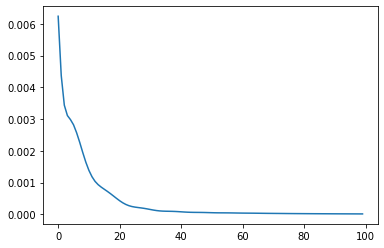

In [335]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [336]:
lg, lb, loss = evaluate(model, graph, node_features, node_labels, test_mask)

In [337]:
print(len(lg.squeeze()))

1140


In [339]:
diff = []
for idx, _ in enumerate(lg.squeeze()):
    pred = round(lg.squeeze()[idx].item(), 5)
    true = round(lb[idx].item(), 5)
    diff.append(pred-true)

In [341]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

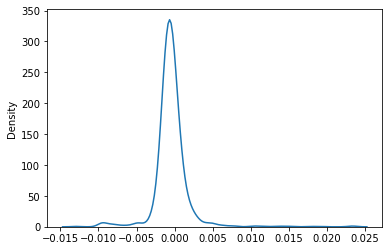

In [252]:
from dgl.data import DGLBuiltinDataset
from dgl.data.utils import _get_dgl_url

class CitationGraphDataset(DGLBuiltinDataset):
    _urls = {
        'cora_v2' : 'dataset/cora_v2.zip',
        'citeseer' : 'dataset/citeseer.zip',
        'pubmed' : 'dataset/pubmed.zip',
    }

    def __init__(self, name, raw_dir=None, force_reload=False, verbose=True):
        assert name.lower() in ['cora', 'citeseer', 'pubmed']
        if name.lower() == 'cora':
            name = 'cora_v2'
        url = _get_dgl_url(self._urls[name])
        super(CitationGraphDataset, self).__init__(name,
                                                   url=url,
                                                   raw_dir=raw_dir,
                                                   force_reload=force_reload,
                                                   verbose=verbose)

    def process(self):
        # Skip some processing code
        # === data processing skipped ===

        # build graph
        g = dgl.graph(graph)
        # splitting masks
        g.ndata['train_mask'] = train_mask
        g.ndata['val_mask'] = val_mask
        g.ndata['test_mask'] = test_mask
        # node labels
        g.ndata['label'] = torch.tensor(labels)
        # node features
        g.ndata['feat'] = torch.tensor(_preprocess_features(features),
                                       dtype=F.data_type_dict['float32'])
        self._num_labels = onehot_labels.shape[1]
        self._labels = labels
        # reorder graph to obtain better locality.
        self._g = dgl.reorder_graph(g)

    def __getitem__(self, idx):
        assert idx == 0, "This dataset has only one graph"
        return self._g

    def __len__(self):
        return 1

In [253]:
# load data

from dgl.data import CiteseerGraphDataset

dataset = CiteseerGraphDataset(raw_dir='')
graph = dataset[0]

# get split masks
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']

# get node features
feats = graph.ndata['feat']

# get labels
labels = graph.ndata['label']

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [254]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [255]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)


In [256]:
print(n_features, n_labels)

3703 6


In [257]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)


In [258]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features)
    print(logits[train_mask].shape, node_labels[train_mask].shape)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    print(loss)
    # compute validation accuracy
    acc = evaluate(model, graph, node_features, node_labels, valid_mask)
    print(acc)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

    # Save model if necessary.  Omitted in this example.

torch.Size([120, 6]) torch.Size([120])
tensor(1.7928, grad_fn=<NllLossBackward>)
0.128
1.7928236722946167
torch.Size([120, 6]) torch.Size([120])
tensor(1.7777, grad_fn=<NllLossBackward>)
0.18
1.7777161598205566
torch.Size([120, 6]) torch.Size([120])
tensor(1.7628, grad_fn=<NllLossBackward>)
0.228
1.7628495693206787
torch.Size([120, 6]) torch.Size([120])
tensor(1.7474, grad_fn=<NllLossBackward>)
0.31
1.747405767440796
torch.Size([120, 6]) torch.Size([120])
tensor(1.7311, grad_fn=<NllLossBackward>)
0.344
1.7311254739761353
torch.Size([120, 6]) torch.Size([120])
tensor(1.7139, grad_fn=<NllLossBackward>)
0.382
1.7139358520507812
torch.Size([120, 6]) torch.Size([120])
tensor(1.6959, grad_fn=<NllLossBackward>)
0.428
1.6958822011947632
torch.Size([120, 6]) torch.Size([120])
tensor(1.6772, grad_fn=<NllLossBackward>)
0.474
1.6771594285964966
torch.Size([120, 6]) torch.Size([120])
tensor(1.6577, grad_fn=<NllLossBackward>)
0.494
1.657720685005188
torch.Size([120, 6]) torch.Size([120])
tensor(1.63

In [107]:
len(graph.nodes[0][0]["feat"][0])

3703

In [97]:
graphs.nodes = dgl.view.HeteroNodeView(graphs.nodes)

TypeError: __init__() missing 1 required positional argument: 'typeid_getter'

In [125]:
graph.nodes[0]

NodeSpace(data={'feat': tensor([[0.0361]], dtype=torch.float64), 'label': tensor([0.0361], dtype=torch.float64), 'train_mask': tensor([True]), 'val_mask': tensor([False]), 'test_mask': tensor([False]), 'h': tensor([[0.0361]]), 'neigh': tensor([[0.]])})

In [119]:
graph.nodes[0]

NodeSpace(data={'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3]), 'test_mask': tensor([False]), 'train_mask': tensor([True]), 'val_mask': tensor([False])})